In [ ]:
def getSource(sourceNum):
    count=0
    running=False
    curString=''
    f = open('/data/fermi_data_1-8-14/gll_psc_v07.xml')
    for i, line in enumerate(f):
        if i<2:continue
        
        if '<source Energy_Flux' in line: count+=1 
        
        if ('<source Energy_Flux' in line) and (count==sourceNum): 
            running=True
            #print count, running
        if running==True: 
            curString+=line
            if "</source>" in line: 
                break
    return curString

        
from astropy import units as u
from astropy.coordinates import SkyCoord

def radec2gal(ra,dec):
    c = SkyCoord(ra, dec, 'icrs',unit=(u.degree, u.degree))
    l,b= c.galactic.l.degree,c.galactic.b.degree
    if l > 180: l-=360.
    return l,b


sourceList, sourceList2 = [],[]

for j in range(1,1862):
    source=getSource(j)       
    #print j, len(source)

    RA,DEC = None,None
    for line2 in source.split('\n'):
        if "RA" in line2 : RA=float(line2.split('value="')[1][:-4])
        if "DEC" in line2 : DEC=float(line2.split('value="')[1][:-4])
    if RA == None: continue # ignore extended sources for now
    
    l,b = radec2gal(RA,DEC)
    #print l,b
    #if np.abs(l)>30 or np.abs(b)>30: continue
    if (l<0) and (l>-30) and (np.abs(b)<30):
        print j, l, b
        sourceList.append(j)
    if (l>0) and (l<30) and (np.abs(b)<30):
        print j, l, b
        sourceList2.append(j)


In [100]:
print len(sourceList)
print len(sourceList2)


140
131


In [194]:
total_array = None

for i in range(1,1863):
    f2 = open('/data/fermi_data_1-8-14/tmpSources.xml','wb')
    modString = ''
    modString += getSource(i)
    print "running", i,i
    
    f2.write('''<?xml version="1.0" ?>
<source_library title="source library">
''')
    f2.write(modString)
    f2.write('''
</source_library>
    ''')
    f2.flush()
    f2.close()
    
    runString ='''cd /data/fermi_data_1-8-14/ ; gtsrcmaps scfile="lat_spacecraft_merged.fits" outfile="gtsrcmap_ALL_BOTH.fits" expcube="cube_ALL_BOTH.fits" cmap="gtbin_ALL_BOTH.fits" bexpmap="gtexpcube2_ALL_BOTH" irfs=P7REP_CLEAN_V15 srcmdl="''' + 'tmpSources.xml' +  ''' " '''

    # Run Galprop
    import sys
    import subprocess 
    p = subprocess.Popen([runString ,], stdout=subprocess.PIPE,stderr=subprocess.PIPE,shell=True)
    
    # Grab stdout line by line as it becomes available.  This will loop until p terminates.
    while p.poll() is None:
        l = p.stdout.readline() # This blocks until it receives a newline.
        sys.stdout.flush()
        print l.rstrip('\n') 
    print p.stderr.read()
    
    import pyfits
    hdu = pyfits.open('/data/fermi_data_1-8-14/gtsrcmap_ALL_BOTH.fits')
    if total_array==None:total_array = hdu[3].data
    else: total_array += hdu[3].data
    
    import cPickle    
    np.save(open('/data/fermi_data_1-8-14/total_srcMap_'+str(i)+'.npy','wb'),total_array)
    try:
        p = subprocess.Popen(['rm /data/fermi_data_1-8-14/total_srcMap_'+str(i-1)+'.npy' ,], 
                     stdout=subprocess.PIPE,stderr=subprocess.PIPE,shell=True)
    except:pass
    
    
    

running 1 1

Generating SourceMap for 2FGL J1326.4-4729.....................!

running

ERROR: KeyboardInterrupt [IPython.core.interactiveshell]
ERROR:astropy:KeyboardInterrupt


 2 2


KeyboardInterrupt: 

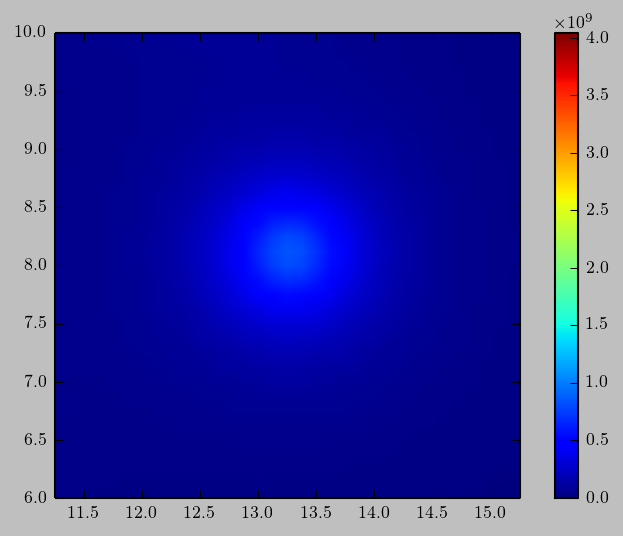

0 9.00138e+10
1 9.82723e+10
2 1.04878e+11
3 1.10216e+11
4 1.14405e+11
5 1.19107e+11
6 1.2409e+11
7 1.28694e+11
8 1.34214e+11
9 1.38655e+11
10 1.44213e+11
11 1.50808e+11
12 1.54998e+11
13 1.59666e+11
14 1.6434e+11
15 1.66046e+11
16 1.68342e+11
17 1.67251e+11
18 1.66164e+11
19 1.67803e+11
20 1.67651e+11
21 1.69352e+11
22 1.73387e+11
23 1.64653e+11
24 1.14676e+11


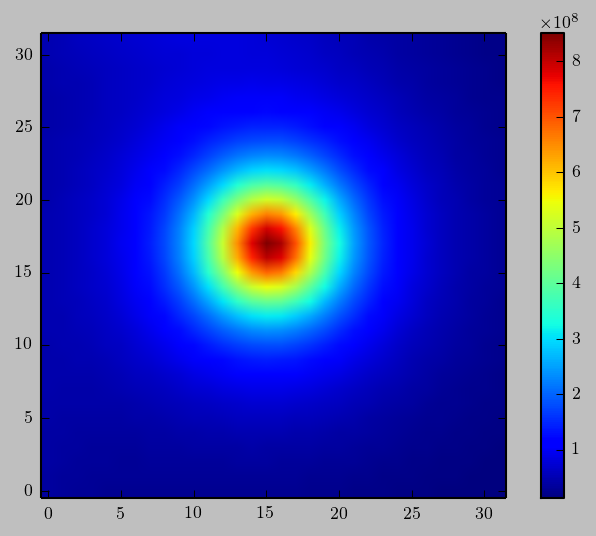

In [185]:
#import pyfits
#hdu = pyfits.open('/data/fermi_data_1-8-14/gtsrcmap_ALL_BOTH_2_2.fits')
#hdu.info()


#total = np.load('/data/fermi_data_1-8-14/point_source_maps/total_srcMap_l_0_30_b_-30_30.npy')
#total += np.load('/data/fermi_data_1-8-14/point_source_maps/total_srcMap_l_-30_0_b_-30_30.npy')
total = np.load('/data/fermi_data_1-8-14/point_source_maps/total_srcMap_1861.npy')
im = plt.imshow(total[4],extent=[-180,180,-90,90],origin='lower')
plt.ylim(6,10)
plt.xlim(11.25,15.25)
plt.colorbar(im)
plt.show()


total = np.load('/data/fermi_data_1-8-14/point_source_maps/total_srcMap_1861.npy')
im = plt.imshow(total[4,768:800,1441+90:1563],origin='lower')

for i in range(25):
    print i, np.sum(total[i,768:800,1441+90:1563])


plt.colorbar(im)
plt.show()



In [4]:
#hdu = pyfits.open('/data/fermi_data_1-8-14/gtsrcmap_ALL_BOTH.fits')
#hdu_new = pyfits.PrimaryHDU(data=total,header=hdu[0].header)
#hdu_new.writeto('gtsrcmap_All_Sources.fits',)


#hdu = pyfits.open('gtsrcmap_All_Sources.fits')
#print hdu[0].header.cards

import Tools

def CartesianCountMap2Healpix(cartCube,nside):
    '''
    This is a static function which takes an input cartesian datacube and returns a 2d healpix array.
    It simply maps each cartesian pixel to the healpix grid (individually for each spectral bin). 
    Primarily intended for converting gtsrcmaps output into healpix format.
    params: 
        input:
            cartCube: Fits filename containing the source cartesian countmap
            nside: healpix nside
    '''
    
    hdu = pyfits.open(cartCube)
    
    hpix = np.zeros(shape=(hdu[0].data.shape[0],12*nside**2))
    
    def Getlatlon(i,j):
        l = (i-hdu[0].header['CRPIX1']+1)*hdu[0].header['CDELT1']+hdu[0].header['CRVAL1']
        b = (j-hdu[0].header['CRPIX2']+1)*hdu[0].header['CDELT2']+hdu[0].header['CRVAL2']
        return l,b
    #print hdu[0].data.shape
    
    i_list = np.arange(hdu[0].data.shape[2])
    
    # iterate over latitudes
    for j in range(hdu[0].data.shape[1]):
        l,b = Getlatlon(i_list,j)
        
        hpixIndex = Tools.ang2hpix(l,b,nside)
        # iterate over energy bins 
        for i_E in range(hpix.shape[0]):
            hpix[i_E,hpixIndex]+=hdu[0].data[i_E,j]
    return hpix
    
hpix = CartesianCountMap2Healpix('gtsrcmap_All_Sources.fits',256)

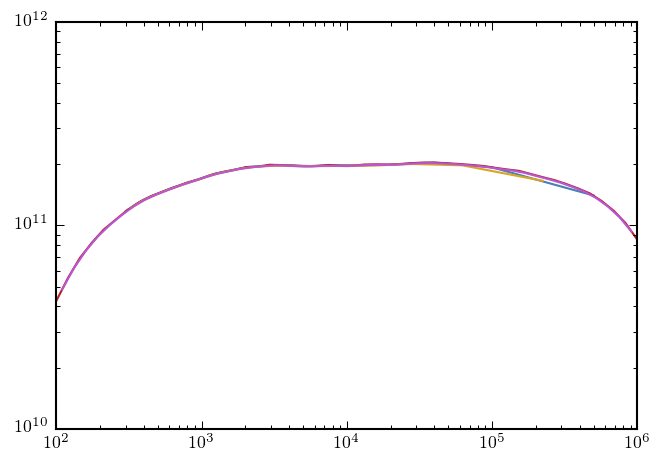

In [3]:
import healpy
import Tools
import Analysis

A = Analysis.Analysis()
#healpy.mollview(np.log10(hpix[0]))

a = np.arange(12*256**2)
l,b = Tools.hpix2ang(a,nside=256)


PSC = np.load('./PSC_P7REP_CLEAN_V15_calore.npy')
#healpy.mollview(np.log10(PSC[0]))
eff_area = np.array([Tools.GetExpMap(A.bin_edges[i_E],A.bin_edges[i_E+1],0,0,
                                     './gtexpcube2_P7REP_CLEAN_V15_calore.fits') for i_E in range(A.n_bins)])

prefix_bins=np.logspace(2,6,50)
eff_area2 = np.array([Tools.GetExpMap(prefix_bins[i_E],prefix_bins[i_E+1],0,0,
                                     './gtexpcube2_P7REP_CLEAN_V15_calore_high_res.fits',) for i_E in range(len(prefix_bins)-1)])

central_energies = 10**np.array([0.5*(np.log10(A.bin_edges[i_E])+np.log10(A.bin_edges[i_E+1])) for i_E in range(A.n_bins)])
central_energies2 = 10**np.array([0.5*(np.log10(prefix_bins[i_E])+np.log10(prefix_bins[i_E+1])) for i_E in range(len(prefix_bins)-1)])



hdu = pyfits.open('./gtexpcube2_P7REP_CLEAN_V15_calore.fits')
hdu2 = pyfits.open('./gtexpcube2_P7REP_CLEAN_V15_calore_high_res.fits')

exp = [hdu[0].data[i, 181, 361] for i in range(len(hdu[1].data.field(0)))]
exp2 = [hdu2[0].data[i, 181, 361] for i in range(len(hdu2[1].data.field(0)))]

plt.plot(hdu[1].data.field(0), exp)
plt.plot(hdu2[1].data.field(0), exp2)


#PSC = np.load('./PSC_P7REP_CLEAN_V15_calore.npy')

plt.plot(central_energies, eff_area)
plt.plot(central_energies2, eff_area2)


#plt.plot(eff_area2/eff_area)

plt.xscale('log')
plt.yscale('log')




Filename: /data/fermi_data_1-8-14/gtsrcmap_ALL_BOTH.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      50   (2881, 1441, 24)   float32   
1    GTI         BinTableHDU     33   32441R x 2C   [D, D]   
2    EBOUNDS     BinTableHDU     38   24R x 3C     [I, 1E, 1E]   
3    2FGL J0057.9-3236  ImageHDU        24   (2881, 1441, 25)   float32   
4    2FGL J2018.0+3626  ImageHDU        24   (2881, 1441, 25)   float32   
('XTENSION', 'IMAGE', 'IMAGE extension')
('BITPIX', -32, 'number of bits per data pixel')
('NAXIS', 3, 'number of data axes')
('NAXIS1', 2881, 'length of data axis 1')
('NAXIS2', 1441, 'length of data axis 2')
('NAXIS3', 25, 'length of data axis 3')
('PCOUNT', 0, 'required keyword; must = 0')
('GCOUNT', 1, 'required keyword; must = 1')
('EXTNAME', '2FGL J0057.9-3236', '')
('CHECKSUM', 'fYocfYmafYmafYma', 'HDU checksum updated 2014-11-19T12:08:19')
('DATASUM', '2024262660', 'data unit checksum updated 2014-11-19T12:08:19')
('CRPIX1', 

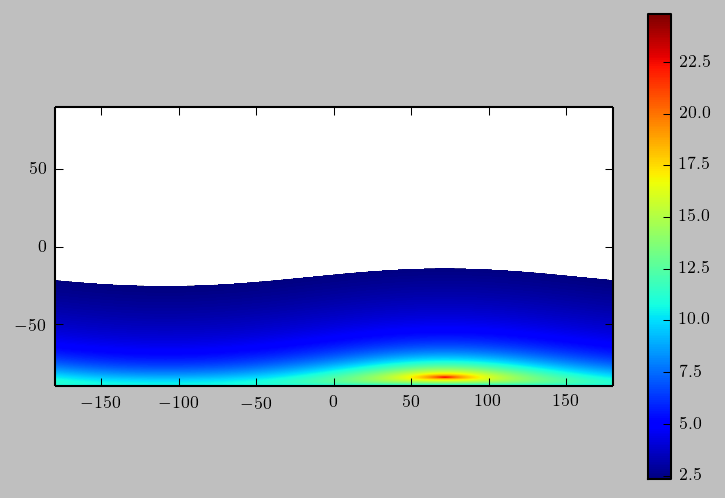

In [62]:

total_array = np.load(open('/data/fermi_data_1-8-14/total_srcMap_0.npy','rb'))
#im = plt.imshow(total_array[0],extent=[-180,180,-90,90],origin='lower')
#plt.colorbar(im)
#plt.xlim(94,100)
#plt.ylim(-5,0)

hdu = pyfits.open('/data/fermi_data_1-8-14/gtsrcmap_ALL_BOTH.fits')
hdu.info()

im = plt.imshow(np.log(np.sum(hdu[3].data,axis=0)),extent=[-180,180,-90,90],origin='lower')
plt.colorbar(im)

print hdu[3].header.cards
print len(hdu)


In [ ]:


for i in range(1873//5+1):
    startSource = i*5+1
    endSource   = (i+1)*5
    if endSource>=1873: endSource=1873
    
    import tempfile
    f2 = tempfile.NamedTemporaryFile()
    
    
    #f2 = open('/data/fermi_data_1-8-14/tmp_src.xml','wb')
    modString = ''
    for i_source in range(startSource,endSource+1):
        modString += getSource(i_source)
    print "running", startSource, endSource
    
    f2.write('''<?xml version="1.0" ?>
<source_library title="source library">
''')
    f2.write(modString)
    f2.write('''
</source_library>
    ''')
    f2.close()
    
    runString ='''cat <<EOS | qsub -V -q hyper -S /bin/bash -N gtsrcmap'''+ str(i) +
                ''' -l nodes=1:ppn=1,walltime=00:20:00,pmem=6G - '''+
                '''cd /pfs/carlson/ ; ''' +
                '''gtsrcmaps scfile="lat_spacecraft_merged.fits" outfile="gtsrcmap_ALL_BOTH_'''+str(i)+'''.fits" '''+  
                ''' expcube="cube_ALL_BOTH.fits" cmap="gtbin_ALL_BOTH.fits" bexpmap="gtexpcube2_ALL_BOTH" ''' +
                ''' irfs=P7REP_CLEAN_V15 srcmdl="''' + f2.name +  ''' " EOS'''            
                
    print runString
    
    # Run Galprop
    import sys
    import subprocess 
    p = subprocess.Popen([runString ,],shell=True)

Filename: //data/fermi_data_1-8-14/gtsrcmap_ALL_BOTH.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      50   (2881, 1441, 24)   float32   
1    GTI         BinTableHDU     33   32441R x 2C   [D, D]   
2    EBOUNDS     BinTableHDU     38   24R x 3C     [I, 1E, 1E]   
3    2FGL J1328.5-4728  ImageHDU        24   (2881, 1441, 25)   float32   


/home/carlson/ipython/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


<matplotlib.colorbar.Colorbar instance at 0x7f8194c31cb0>

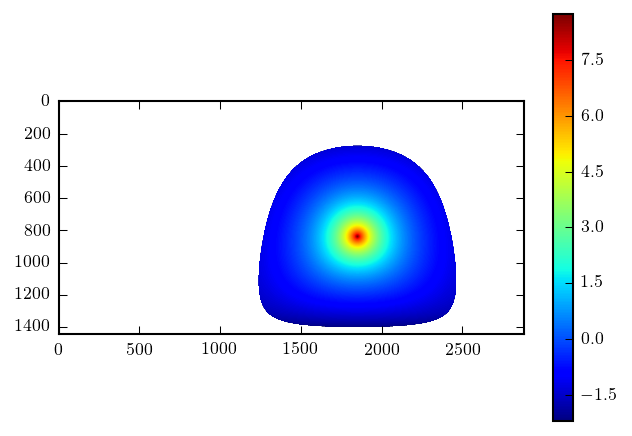

In [1]:
hdu = pyfits.open('//data/fermi_data_1-8-14/gtsrcmap_ALL_BOTH.fits')
hdu.info()
plt.imshow(np.log10(hdu[3].data[2]))
plt.colorbar()

#print hdu[0].header.cards

[(1, 300000.0, 350000.0) (2, 350000.0, 400000.0) (3, 400000.0, 450000.0)
 (4, 450000.0, 500000.0) (5, 500000.0, 557451.19) (6, 557451.19, 624993.12)
 (7, 624993.12, 705081.19) (8, 705081.19, 800954.75)
 (9, 800954.75, 916954.5) (10, 916954.5, 1058999.5)
 (11, 1058999.5, 1235321.9) (12, 1235321.9, 1457629.9)
 (13, 1457629.9, 1743009.4) (14, 1743009.4, 2117148.0)
 (15, 2117148.0, 2620038.0) (16, 2620038.0, 3316585.8)
 (17, 3316585.8, 4317572.5) (18, 4317572.5, 5824226.5)
 (19, 5824226.5, 8232172.0) (20, 8232172.0, 12404649.0)
 (21, 12404649.0, 20517116.0) (22, 20517116.0, 39361808.0)
 (23, 39361808.0, 99337184.0) (24, 99337184.0, 5e+08)]


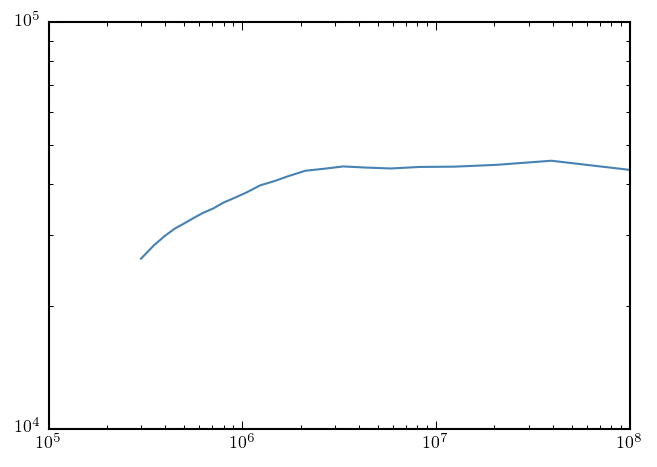

In [3]:

print hdu.


val = [np.mean(hdu[3].data[i])/ for i in range(25)]
print hdu[2].data

energies = [np.sum(hdu[2].data[i][1]) for i in range(24)]
plt.loglog(energies,val[:-1])
    